# Workshop Preparations
2024-10-21 daniel.flemstrom@ri.se , nuria.agues.paszkowsky@ri.se


# Skicka en geometri och få tillbaka saker:
1. <span style="color:red">en tidsserie med medelvärden **(över en geometri?)**</span>
, 
2. <span style="color:green">en bild att titta på **(TCI (RGB image))**</span>,
3. <span style="color:green">alla banddata, **(Blir lite knepigt, måste läsa en kub per upplösning)**</span>
4. <span style="color:green">ndvi-värden **(använd ndvi processen från tutorial)**</span>
5. <span style="color:green">molnmaskerad bild, **(SCL maskerad)***</span>
6. <span style="color:green">skugg%,  **( SCL, vilken flagga )**</span>
7. <span style="color:green">moln%,  **(SCL samma flagga som molnmask)**</span>


## 1. Tidsserie med medelvärden

In [13]:
import openeo
from config import user,passwd,eo_service_url
import io
import rasterio.plot
import numpy as np
from demo_regions import s2
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [14]:

connection = openeo.connect(eo_service_url) 
connection.authenticate_basic(username=user, password=passwd)

<Connection to 'https://openeo.digitalearth.se/' with BasicBearerAuth>

In [22]:
nmd_cube = conn.load_collection(
    "NMD_Produktivitet_v1_1",
    bands=["produktivitet"],  # Correctly specify the band
    spatial_extent=s2.polygons.d,
    temporal_extent=[],
)

# Mask everything that isn't "produktiv skogsmark"
nmd_mask = ~(nmd_cube == 1)
nmd_mask = nmd_mask.reduce_dimension(dimension="t", reducer="first") # We need to reduce time dimension to be able to use this as a mask (non ideal workaround)
nmd_mask

In [16]:
# Load S2MSI2A data
cube = conn.load_collection(
    s2.s2_msi_l2a,
    bands=["b11", "scl"],
    spatial_extent=s2.polygons.d,
    temporal_extent=["2020-03-01", "2020-08-01"],
    #max_cloud_cover=50, TODO this should work, need to fix
)

# we want to mask all other values, so NOT (2 OR 4 OR 5 OR 6)
scl =  cube.band("scl")
scl_mask = ~ ((scl == 2) | (scl == 4) | (scl == 5)  | (scl == 6))
scl_mask

In [25]:
# Get the b11 band, apply the masks, and calculate the median over the polygon
from openeo.processes import merge_cubes
b11 = cube.band("b11")
b11 = b11.mask(scl_mask)
#b11 = b11.mask(nmd_mask)
median_agg = b11.aggregate_spatial(geometries = s2.polygons.d, reducer = "median")
median_agg

In [26]:
%time res = median_agg.execute()

CPU times: user 18.4 ms, sys: 1.25 ms, total: 19.6 ms
Wall time: 2min 50s


In [34]:
# Unpack the response
medians = np.array(res["data"][0])
#times = np.array(res["t"])

In [ ]:
# Unpack the response
medians = np.array(res["data_vars"]["values"]["data"][0])
times = np.array(res["coordinates"]["t"])

In [37]:
# Create None filter
valid_idxs = np.where(medians != None)[0]

In [ ]:
%time pixel_count = (~scl_mask).aggregate_spatial(geometries = polygon, reducer = "sum").execute()
number_of_usable_pixels = pixel_count["data"][0]
max_number_of_usable_pixels = np.max(number_of_usable_pixels)
valid_idxs2 = np.where(np.array(number_of_usable_pixels) > max_number_of_usable_pixels * .98)[0]

In [ ]:
# Merge None and cloud filters
valid_idx_intersection = set(valid_idxs).intersection(valid_idxs2)
valid_idx_intersection = list(valid_idx_intersection)
valid_idx_intersection.sort()


# Apply filter
medians = medians[valid_idx_intersection]
times = times[valid_idx_intersection]
times = [datetime.fromtimestamp(timestamp/1e9) for timestamp in times]


print(f"Number of valid observations: {len(valid_idx_intersection)}")

In [ ]:
# Plot values
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(times, medians)
plt.ylabel("median b11")
plt.xlabel("time")
plt.tight_layout()
plt.savefig("median_b11.png", dpi=100, pad_inches=0)

## 2. RGB from Notebook 040_VIZ_010-RGB


--> [RGB bild](../040_VIZ_010-RGB.ipynb)

## 3. All bands

<br> --> [Working with resolutions](./30-Resampling-Bands.ipynb)

## 4. NDVI from Notebook 050_PROC_010-Processes-intro

--> [NDVI](../050_PROC_010-Processes-intro.ipynb)

## 5. SCL masking clouds


In [1]:
import openeo
from config import user,passwd,eo_service_url
import numpy as np
from demo_regions import s2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from demo_helpers import load_netcdf_as_xarray
import pandas as pd

In [2]:
# Connect to OpenEO
conn = openeo.connect(eo_service_url)

conn.authenticate_basic(username=user, password=passwd)

<Connection to 'https://openeo.digitalearth.se/' with BasicBearerAuth>

In [3]:
# 1. Load the data
datacube = conn.load_collection(
    collection_id = "s2_msi_l2a",
    bands=["scl"], 
    spatial_extent=s2.bbox.karlstad_mini_land,
    temporal_extent=["2023-06-12", "2023-06-25"]
)
# Execute the process to retrieve the scl image data for future plotting
scldata = datacube.execute()

# 2. Mask what you want to remove from the image
scl =  datacube.band("scl")
cloud_mask =  ((scl == 8) | (scl == 9) | (scl == 10))
cloudmask_datacube = datacube.mask(cloud_mask) # 8, 9, and 10 represent clouds

When you apply `datacube.mask(cloud_mask)`, the cloud pixels (where cloud_mask is True) in the original data cube are replaced with `None` (or another value if you specify replacement). Non-cloud pixels remain unchanged.

In [4]:
# 3. Execute the process to retrieve the cloud-masked image data
cloud_masked_image = cloudmask_datacube.execute()

Now we need to extract the pixel data for plotting. The clouds have been masked and therefore have a `None` value. We will replace them for a value of `12`to create a new class of masked pixels in SCL.

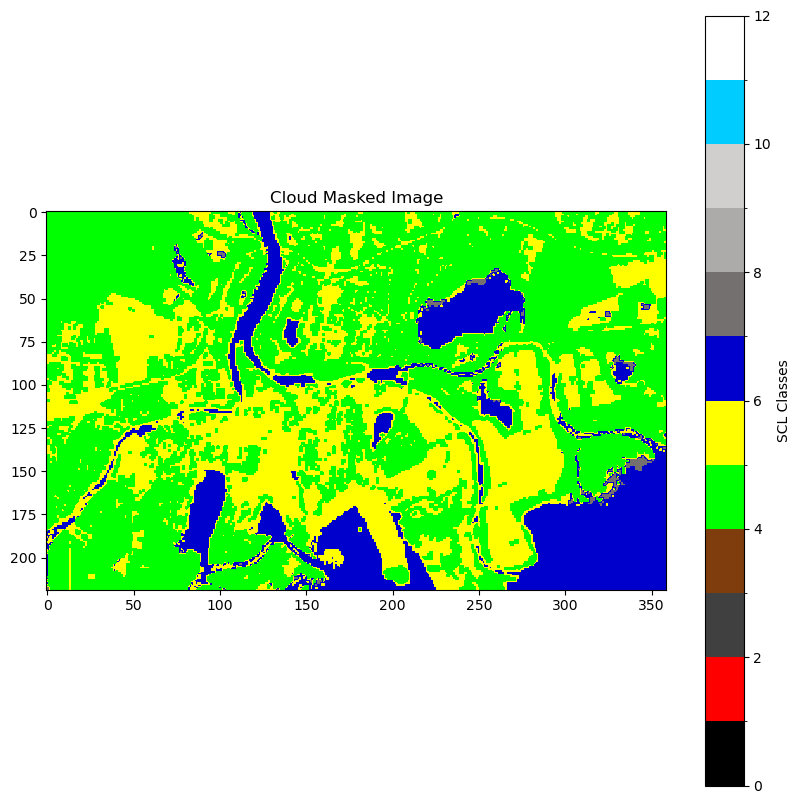

In [5]:
# 4. Extract the pixel data and plot
# timestamp in time series: (t) - change if you want to see a different day
t = 0
# Replace None values with 12 before converting to NumPy array
image_data_raw = cloud_masked_image['data'][0][t]   # First band's data
image_data = np.array(image_data_raw, dtype=float)  # Convert to float for NaN handling
image_data = np.nan_to_num(image_data, nan=12)  # Replace NaN with 0# 5. Define a colormap for the scl values
# Create a custom colormap for the 12 classes (0 to 11)
cmap_scl = ListedColormap(
    [
        '#000000',  # 0: No data (black)
        '#FF0000',  # 1: Saturated or defective (red)
        '#404040',  # 2: Dark area pixels (dark grey)
        '#7F3D0D',  # 3: Cloud shadows (brown)
        '#00FF00',  # 4: Vegetation (green)
        '#FFFF00',  # 5: Not vegetated (yellow)
        '#0000CC',  # 6: Water (blue)
        '#757070',  # 7: Unclassified (grey)
        '#ADAAAA',  # 8: Cloud medium probability (light grey)
        '#D1CECE',  # 9: Cloud high probability (white)
        '#00CCFF',  # 10: Thin cirrus (cyan)
        '#FF66FF',  # 11: Snow or ice (pink)
        '#FFFFFF'   # 12: Masked pixels (white)
    ]
)


norm_scl = BoundaryNorm(range(0, 13), cmap_scl.N)

# 6. Plot the cloud-masked image with the custom colormap and norm
plt.figure(figsize=(10, 10))
plt.imshow(image_data, cmap=cmap_scl, norm=norm_scl)  # Set vmin and vmax to map 0-11 range
plt.title('Cloud Masked Image')
plt.colorbar(label="SCL Classes")
plt.show()

Now we compare the values of SCL and our masked data to double check that the mask worked properly.

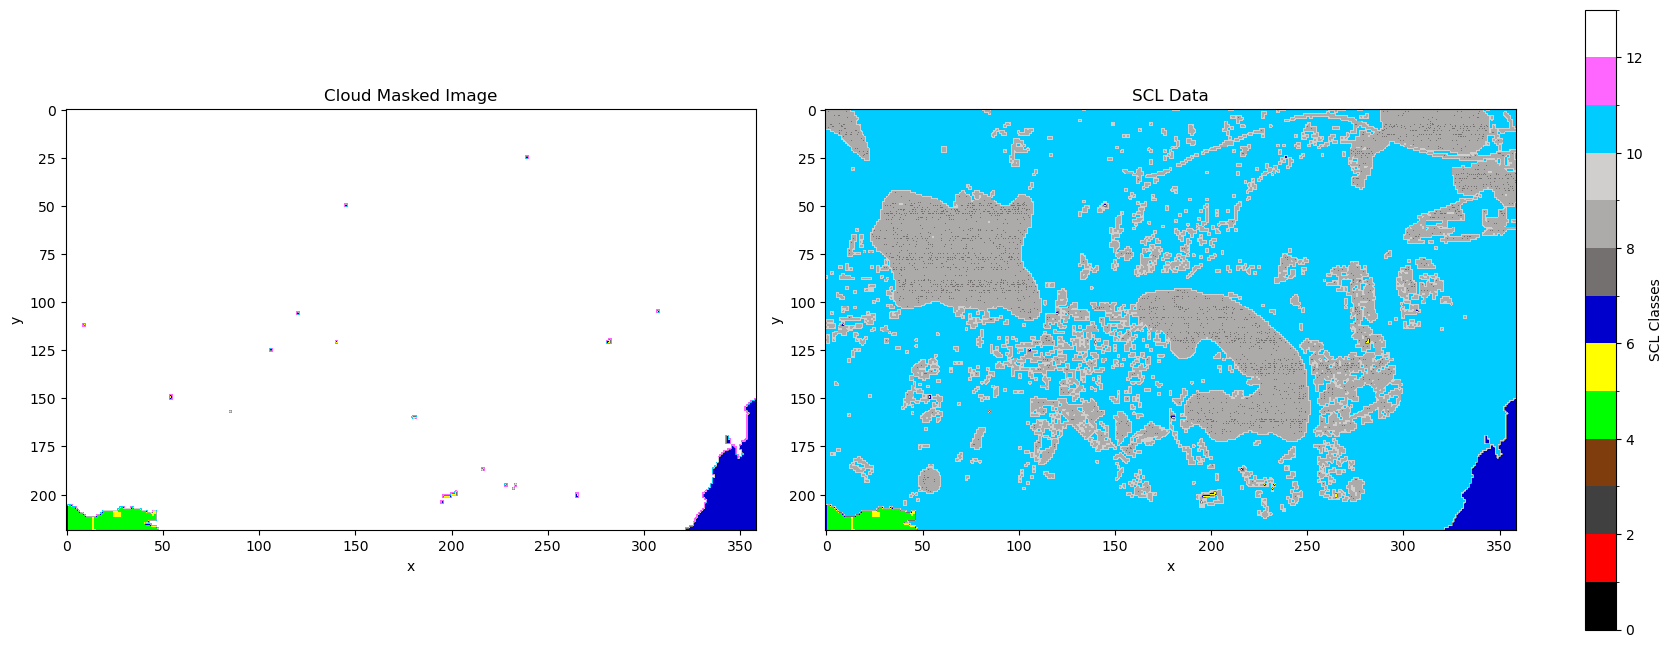

In [6]:
# t is the timestamp we wish to plot. Change to see other days.
t = 1
# 4. Extract the pixel data from the cloud-masked image
image_data_raw = cloud_masked_image['data'][0][t]   # First band's data
image_data = np.array(image_data_raw, dtype=float)  # Convert to float for NaN handling
image_data = np.nan_to_num(image_data, nan=12)  # Replace NaN with 0

# Extract the pixel data from the scldata
scldata_raw = scldata['data'][0][t]  # First band's data for scldata
scldata_image = np.array(scldata_raw, dtype=float)  # Convert to float for NaN handling
scldata_image = np.nan_to_num(scldata_image, nan=0)  # Replace NaN with 0

# 5. Define a colormap for the SCL values
cmap_scl = ListedColormap(
    [
        '#000000',  # 0: No data (black)
        '#FF0000',  # 1: Saturated or defective (red)
        '#404040',  # 2: Dark area pixels (dark grey)
        '#7F3D0D',  # 3: Cloud shadows (brown)
        '#00FF00',  # 4: Vegetation (green)
        '#FFFF00',  # 5: Not vegetated (yellow)
        '#0000CC',  # 6: Water (blue)
        '#757070',  # 7: Unclassified (grey)
        '#ADAAAA',  # 8: Cloud medium probability (light grey)
        '#D1CECE',  # 9: Cloud high probability (white)
        '#00CCFF',  # 10: Thin cirrus (cyan)
        '#FF66FF',  # 11: Snow or ice (pink)
        '#FFFFFF'   # 12: Masked pixels (white)
    ]
)

norm_scl = BoundaryNorm(range(0, 14), cmap_scl.N)

# 6. Plot both images side by side with the custom colormap and norm
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Create subplots (1 row, 2 columns)

# Plot the cloud-masked image
im1 = axes[0].imshow(image_data, cmap=cmap_scl, norm=norm_scl)
axes[0].set_title('Cloud Masked Image')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Plot the SCL data image
im2 = axes[1].imshow(scldata_image, cmap=cmap_scl, norm=norm_scl)
axes[1].set_title('SCL Data')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap_scl, norm=norm_scl), ax=axes, orientation='vertical', fraction=0.02, pad=0.06)
cbar.set_label("SCL Classes")
fig.subplots_adjust(wspace=0.1, right=0.85)  # Add horizontal space between the plots

plt.show()


## 7. Percentage of cloud

Get the timestamps from the original datacube to plot the time series and use the dates as labels in the axis. 

In [7]:
downloaded_dc = datacube.download(format="netcdf")

The function load_netcdf_as_xarray reads the downloaded datacube and opens it as xarray so we can access the timestamps. 

In [8]:
xarraydc = load_netcdf_as_xarray(downloaded_dc)
timestamps = np.array(xarraydc.t.values)

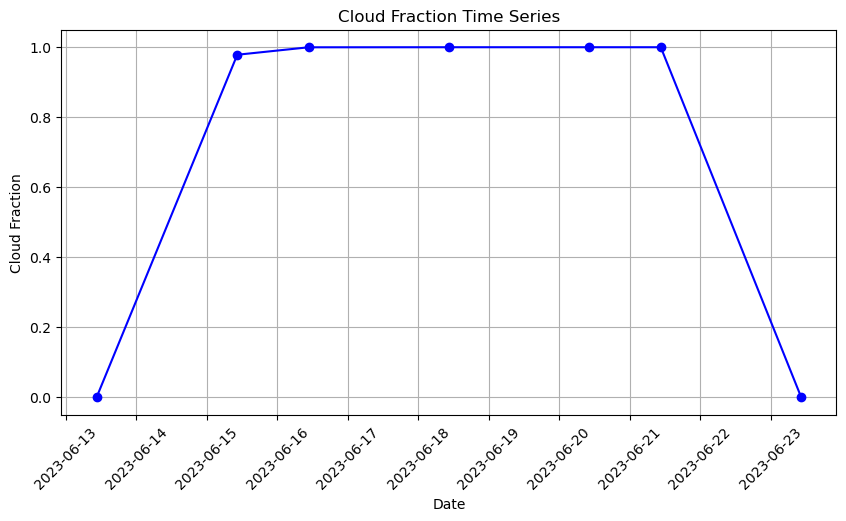

In [9]:

# 1. Reduce the spatial dimension by calculating the fraction of cloudy pixels per time step.
cloud_fraction_timeseries = cloud_mask.reduce_dimension(
    dimension="x",  # Reducing along the x (longitude) axis
    reducer="mean"
).reduce_dimension(
    dimension="y",  # Then reducing along the y (latitude) axis
    reducer="mean"
)

# 2. Execute the process to get the time series result
time_series = cloud_fraction_timeseries.execute()

# 3. Extract cloud fraction values directly
cloud_fractions = time_series['data']  # Assuming the first band contains cloud fractions


timestamps = np.array(xarraydc.t.values)

# 4. Plot the data
plt.figure(figsize=(10, 5))
plt.plot(timestamps, cloud_fractions, marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Cloud Fraction')
plt.title('Cloud Fraction Time Series')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [10]:
print(time_series)

{'data': [0.0, 0.9785044708156854, 0.9997964920313912, 1.0, 1.0, 1.0, 0.0], 'dims': ['t'], 'attrs': {'crs': 'EPSG:3006', 'grid_mapping': 'spatial_ref', 'nodata': None, 'collection': 's2_msi_l2a', 'reduced_dimensions_min_values': {'bands': 'scl', 'x': 412510.0, 'y': 6581370.0}}}


## 6. Percentage of cloud shadow

We use `scl` from the previous sections to create a shadow mask. The same way we plotted the cloud time series above we can plot it for cloud shadows here.

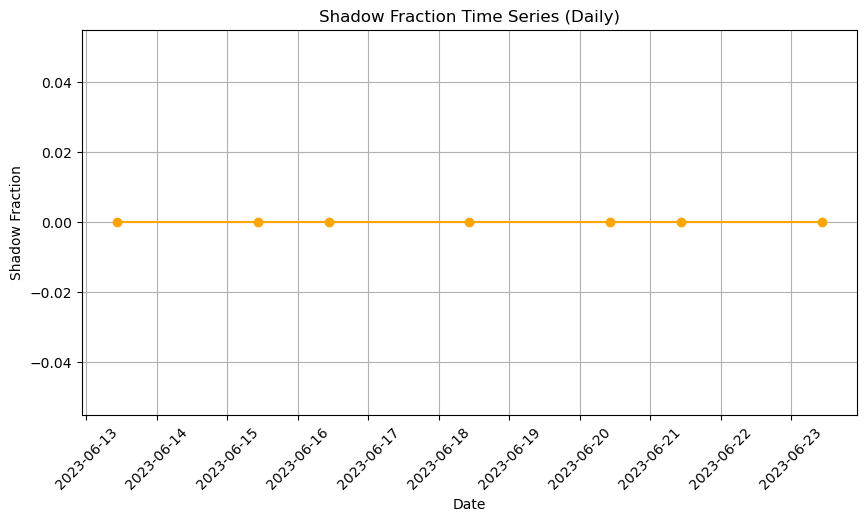

In [11]:
# 1. Create the shadow mask from the datacube
scl = datacube.band("scl")
shadow_mask = (scl == 3)  # Shadow mask

# 2. Apply the mask and reduce the spatial dimensions to calculate the fraction of shadow pixels per time step.
shadow_fraction_timeseries = shadow_mask.reduce_dimension(
    dimension="x",  # Reducing along the x (longitude) axis
    reducer="mean"
).reduce_dimension(
    dimension="y",  # Then reducing along the y (latitude) axis
    reducer="mean"
)

# 3. Execute the process to get the time series result
time_series2 = shadow_fraction_timeseries.execute()

# 4. Extract shadow fraction values directly
shadow_fractions = time_series2['data']  # Assuming the first band contains shadow fractions


# Get timestamps from the original datacube
timestamps = np.array(xarraydc.t.values)
# 5. Plot the data
plt.figure(figsize=(10, 5))
plt.plot(timestamps, shadow_fractions, marker='o', linestyle='-', color='orange')
plt.xlabel('Date')
plt.ylabel('Shadow Fraction')
plt.title('Shadow Fraction Time Series (Daily)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [12]:
time_series2


{'data': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'dims': ['t'],
 'attrs': {'crs': 'EPSG:3006',
  'grid_mapping': 'spatial_ref',
  'nodata': None,
  'collection': 's2_msi_l2a',
  'reduced_dimensions_min_values': {'bands': 'scl',
   'x': 412510.0,
   'y': 6581370.0}}}

# Antal pixlar med vegetation (Daniel)

# Bild med moln, bild utan moln
# Tänkt att använda filter_quality, filter fine_quality (Daniel makes a figure)

# data från andra myndigheter
(ta deras SKS Cloud index grejorna som vi pillrat med för qindex)

- Interpolera direkt i bilderna, applicera ”curnals” (beräkningsrutor)
kernels????, menas indexrutorna ??? (Skrivit till Viktoria)


# Applicera något känt som tex är gjort på höjdmodellen, på något annat
- läsa in höjdmodell (kan vi ju inte göra, den måste göras produkt, stac_item.json och indexeras)

